In [6]:
import os
import pandas as pd
import numpy as np
from glob import glob
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold # Penting: Kembali ke GroupKFold
from sklearn.impute import SimpleImputer # Untuk penanganan NaN setelah ekstraksi fitur
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, StackingClassifier, StackingRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns # Untuk visualisasi yang lebih baik

# --- Konfigurasi Jalur Data ---
# Pastikan ini menunjuk ke direktori 'csv' yang berisi folder subjek (misalnya, '01-9TZK')
BASE_DIR = "H:/emoWear/csv_features/csv"

# Daftar file sensor yang akan dimuat dari setiap folder subjek
sensor_files = {
    "eda": "signals-e4-eda.csv",
    "temp": "signals-e4-temp.csv",
    "hr": "signals-e4-hr.csv",
    "acc": "signals-e4-acc.csv",
    # Tambahkan sensor lain jika ada dan relevan
    # "bvp": "signals-e4-bvp.csv",
    # "skt": "signals-e4-skt.csv",
    # "ibi": "signals-e4-ibi.csv",
    # "rr": "signals-bh3-rr.csv", # Contoh dari sensor lain jika ada
}

# Periksa apakah BASE_DIR ada
if not os.path.exists(BASE_DIR):
    print(f"Error: Direktori dasar tidak ditemukan di {BASE_DIR}. Pastikan Anda telah mengarahkan ke folder yang benar.")
    exit()

print(f"Direktori dasar yang digunakan: {BASE_DIR}")


Direktori dasar yang digunakan: H:/emoWear/csv_features/csv


In [2]:
def load_and_merge_signals(subject_path):
    """
    Memuat dan menggabungkan data sinyal dari berbagai file sensor
    untuk subjek tertentu.
    """
    dfs = []
    for key, filename in sensor_files.items():
        file_path = os.path.join(subject_path, filename)
        if not os.path.exists(file_path):
            # print(f"  Peringatan: File {filename} tidak ditemukan di {subject_path}. Melewatkan.")
            continue
        try:
            df = pd.read_csv(file_path)
            if 'timestamp' not in df.columns:
                print(f"  Peringatan: File {filename} tidak memiliki kolom 'timestamp'. Melewatkan.")
                continue
            df = df.set_index("timestamp")
            # Ganti nama kolom untuk menghindari konflik dan menunjukkan sumber sensor
            df.columns = [f"{key}_{col}" for col in df.columns]
            dfs.append(df)
        except Exception as e:
            print(f"  Error memuat/memproses {filename} di {subject_path}: {e}")
            continue

    if dfs:
        # Menggabungkan semua DataFrame berdasarkan indeks timestamp
        # dropna(axis=1, how='all') untuk menghapus kolom yang sepenuhnya NaN
        merged_df = pd.concat(dfs, axis=1).reset_index().dropna(axis=1, how='all')
        # Downcast float64 ke float32 untuk menghemat memori
        for col in merged_df.select_dtypes(include=['float64']).columns:
            merged_df[col] = merged_df[col].astype(np.float32)
        return merged_df
    return None

def extract_features(df_window):
    """
    Mengekstrak fitur statistik dasar (mean, std, min, max) dari jendela DataFrame.
    """
    features = {}
    # Kolom 'timestamp' tidak boleh diekstrak fiturnya
    feature_cols_in_window = [col for col in df_window.columns if col != "timestamp"]

    if df_window.empty or not feature_cols_in_window:
        return {} # Kembalikan dict kosong jika jendela kosong atau tidak ada kolom fitur

    for col in feature_cols_in_window:
        # Pastikan kolom adalah tipe numerik sebelum menghitung statistik
        if pd.api.types.is_numeric_dtype(df_window[col]):
            features[f"{col}_mean"] = np.mean(df_window[col])
            features[f"{col}_std"] = np.std(df_window[col])
            features[f"{col}_min"] = np.min(df_window[col])
            features[f"{col}_max"] = np.max(df_window[col])
        else:
            # print(f"  Peringatan: Kolom non-numerik '{col}' dilewati untuk ekstraksi fitur.")
            pass # Lewati kolom non-numerik

    return features

# --- Tambahan: Fungsi untuk menangani NaN setelah ekstraksi fitur ---
# Ini akan digunakan setelah X_all dikonversi ke DataFrame
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()


In [3]:
X_all_features = [] # List untuk menyimpan dictionary fitur dari setiap jendela
y_valence_all = []  # List untuk menyimpan label valensi biner
y_arousal_all = []  # List untuk menyimpan label gairah kontinu
subject_ids_for_groups = [] # List untuk menyimpan ID subjek untuk GroupKFold

# Menggunakan glob untuk menemukan semua folder subjek
subject_dirs = sorted(glob(os.path.join(BASE_DIR, "*")))

if not subject_dirs:
    print(f"Error: Tidak ada folder subjek yang ditemukan di {BASE_DIR}. Pastikan struktur direktori Anda benar.")
    exit()

print(f"Memulai pengumpulan data dari {len(subject_dirs)} subjek...")

for subject_dir in subject_dirs:
    if not os.path.isdir(subject_dir): # Pastikan itu adalah direktori
        continue

    subject_id = os.path.basename(subject_dir) # ID subjek adalah nama folder

    print(f"Memproses subjek: {subject_id}")

    try:
        # Jalur ke file label dan penanda waktu
        survey_path = os.path.join(subject_dir, "surveys.csv")
        marker_path = os.path.join(subject_dir, "markers-phase2.csv")

        # Periksa keberadaan file penting
        if not (os.path.exists(survey_path) and os.path.exists(marker_path)):
            print(f"  Peringatan: File surveys.csv atau markers-phase2.csv tidak ditemukan untuk {subject_id}. Melewatkan subjek ini.")
            continue

        # Memuat label dan penanda waktu
        survey_df = pd.read_csv(survey_path)
        marker_df = pd.read_csv(marker_path)

        # Memuat dan menggabungkan sinyal sensor
        signal_df = load_and_merge_signals(subject_dir)
        if signal_df is None or signal_df.empty:
            print(f"  Peringatan: Tidak ada data sinyal yang valid atau lengkap untuk {subject_id}. Melewatkan subjek ini.")
            continue

        # Pastikan kolom 'timestamp' adalah float untuk perbandingan waktu
        signal_df["timestamp"] = signal_df["timestamp"].astype(float)

        # Iterasi melalui setiap entri survei/penanda untuk membuat jendela data
        # Asumsi: Setiap baris di survey_df dan marker_df sesuai dengan satu sesi/stimulus
        num_windows = min(len(survey_df), len(marker_df))
        if num_windows == 0:
            print(f"  Peringatan: Tidak ada entri survei atau penanda yang cocok untuk {subject_id}. Melewatkan subjek ini.")
            continue

        for i in range(num_windows):
            # Asumsi 'vidB' adalah waktu mulai stimulus/video
            # Pastikan kolom 'vidB' ada di marker_df
            if 'vidB' not in marker_df.columns:
                print(f"  Error: Kolom 'vidB' tidak ditemukan di markers-phase2.csv untuk {subject_id}. Melewatkan subjek ini.")
                break # Keluar dari loop for i
            start_time = marker_df.iloc[i]["vidB"]
            # Asumsi jendela 60 detik setelah start_time
            window_duration = 60 # detik
            end_time = start_time + window_duration

            # Filter data sinyal untuk jendela waktu saat ini
            window_df = signal_df[(signal_df["timestamp"] >= start_time) & (signal_df["timestamp"] < end_time)]

            # Periksa apakah jendela memiliki cukup data
            min_data_points = 10 # Ambang batas minimum data dalam jendela
            if len(window_df) < min_data_points:
                # print(f"  Peringatan: Jendela {i} untuk {subject_id} memiliki kurang dari {min_data_points} titik data. Melewatkan.")
                continue

            # Ekstrak fitur dari jendela
            features = extract_features(window_df)
            if not features: # Jika tidak ada fitur yang berhasil diekstrak
                # print(f"  Peringatan: Tidak ada fitur yang diekstrak dari jendela {i} untuk {subject_id}. Melewatkan.")
                continue

            # Dapatkan label valensi dan gairah
            # Pastikan kolom 'valence' dan 'arousal' ada di surveys.csv
            if 'valence' not in survey_df.columns or 'arousal' not in survey_df.columns:
                print(f"  Error: Kolom 'valence' atau 'arousal' tidak ditemukan di surveys.csv untuk {subject_id}. Melewatkan.")
                break # Keluar dari loop for i

            valence_label = survey_df.iloc[i]["valence"]
            arousal_label = survey_df.iloc[i]["arousal"]

            # Binarisasi valensi (>= 5 sebagai "tinggi", < 5 sebagai "rendah")
            y_valence_all.append(int(valence_label >= 5))
            y_arousal_all.append(arousal_label) # Arousal tetap kontinu

            # Tambahkan fitur dan ID subjek
            X_all_features.append(features)
            subject_ids_for_groups.append(subject_id) # Simpan ID subjek untuk GroupKFold

    except KeyError as ke:
        print(f"  Error KeyError di {subject_id}: {ke}. Pastikan kolom yang diperlukan (misalnya 'valence', 'arousal' di surveys.csv, 'vidB' di markers-phase2.csv) ada.")
        continue
    except Exception as e:
        print(f"  Error tak terduga saat memproses {subject_id}: {e}")
        continue

print(f"\nPengumpulan data selesai. Total {len(X_all_features)} sampel data dikumpulkan.")


Memulai pengumpulan data dari 48 subjek...
Memproses subjek: 01-9TZK
Memproses subjek: 02-9TZO
Memproses subjek: 03-9U4C
Memproses subjek: 04-9U66
Memproses subjek: 05-9U8B
Memproses subjek: 06-9UA7
Memproses subjek: 07-9UAD
Memproses subjek: 08-9UB2
Memproses subjek: 09-9UDP
Memproses subjek: 10-9UHM
Memproses subjek: 11-9UIZ
Memproses subjek: 12-9UN3
Memproses subjek: 13-9UOF
Memproses subjek: 14-9UP0
Memproses subjek: 15-9UR2
Memproses subjek: 16-9USC
Memproses subjek: 17-9UTL
Memproses subjek: 18-9UVM
Memproses subjek: 19-9UY7
Memproses subjek: 20-9V52
Memproses subjek: 21-9V5J
Memproses subjek: 22-9V5N
Memproses subjek: 23-9VIV
Memproses subjek: 24-9VL3
Memproses subjek: 25-9VNK
Memproses subjek: 26-9VTJ
Memproses subjek: 27-9VUW
Memproses subjek: 28-9VXK
Memproses subjek: 29-9VXR
Memproses subjek: 30-9VYD
Memproses subjek: 31-9VZJ
Memproses subjek: 32-9VZN
Memproses subjek: 33-9VZR
Memproses subjek: 34-9W1R
Memproses subjek: 36-9W4C
Memproses subjek: 37-9W4X
Memproses subjek: 38-

In [4]:
# Konversi list of dictionaries menjadi DataFrame
X_df = pd.DataFrame(X_all_features)

# --- Penanganan Missing Data Lanjutan ---
# Hapus kolom yang sepenuhnya NaN (jika ada fitur yang tidak pernah diekstrak)
X_df = X_df.dropna(axis=1, how='all')

# Imputasi nilai NaN yang tersisa menggunakan mean
# Ini penting karena beberapa fitur mungkin memiliki NaN jika jendela data terlalu kecil atau tidak lengkap
print(f"Shape X_df sebelum imputasi: {X_df.shape}")
# Pastikan semua kolom numerik sebelum imputasi
numeric_cols = X_df.select_dtypes(include=[np.number]).columns
if not numeric_cols.empty:
    X_imputed = imputer.fit_transform(X_df[numeric_cols])
    X_imputed_df = pd.DataFrame(X_imputed, columns=numeric_cols, index=X_df.index)
else:
    print("Peringatan: Tidak ada kolom numerik yang tersisa setelah pembersihan awal. Mungkin ada masalah dengan ekstraksi fitur.")
    X_imputed_df = pd.DataFrame() # DataFrame kosong jika tidak ada kolom numerik

print(f"Shape X_imputed_df setelah imputasi: {X_imputed_df.shape}")

# Penskalaan Fitur
# Penting: scaler harus di-fit hanya pada data pelatihan dalam GroupKFold
# Di sini kita hanya melakukan fit_transform awal untuk mendapatkan gambaran
# Penskalaan sebenarnya akan terjadi di dalam loop GroupKFold
if not X_imputed_df.empty:
    X_scaled_initial = scaler.fit_transform(X_imputed_df)
    # Konversi kembali ke DataFrame untuk memudahkan inspeksi
    X_scaled_df = pd.DataFrame(X_scaled_initial, columns=X_imputed_df.columns, index=X_imputed_df.index)
else:
    X_scaled_df = pd.DataFrame()

y_valence = np.array(y_valence_all)
y_arousal = np.array(y_arousal_all)
groups = np.array(subject_ids_for_groups) # Ini adalah 'groups' untuk GroupKFold

print(f"Total sampel untuk pemodelan: {len(y_valence)}")
print(f"Jumlah fitur: {X_scaled_df.shape[1]}")
print(f"Jumlah subjek unik: {len(np.unique(groups))}")

if len(np.unique(groups)) < 2:
    print("Error: Hanya satu subjek unik yang ditemukan. GroupKFold membutuhkan setidaknya 2 subjek. Tidak dapat melanjutkan.")
    exit()
if len(y_valence) == 0:
    print("Error: Tidak ada sampel data yang valid setelah pra-pemrosesan. Tidak dapat melanjutkan.")
    exit()


Shape X_df sebelum imputasi: (1776, 20)
Shape X_imputed_df setelah imputasi: (1776, 20)
Total sampel untuk pemodelan: 1776
Jumlah fitur: 20
Jumlah subjek unik: 48



Memulai GroupKFold Cross-Validation untuk Valensi dengan 5 folds...

===== Fold 1 (Valensi) =====
  Jumlah sampel pelatihan: 1410, Jumlah sampel pengujian: 366
  Jumlah subjek pelatihan: 38, Jumlah subjek pengujian: 10
  Melatih Stacking Classifier untuk Valensi...
  Valence Accuracy (Fold 1): 0.5628
  Classification Report (Fold 1):
              precision    recall  f1-score   support

 Low Valence       0.00      0.00      0.00       160
High Valence       0.56      1.00      0.72       206

    accuracy                           0.56       366
   macro avg       0.28      0.50      0.36       366
weighted avg       0.32      0.56      0.41       366



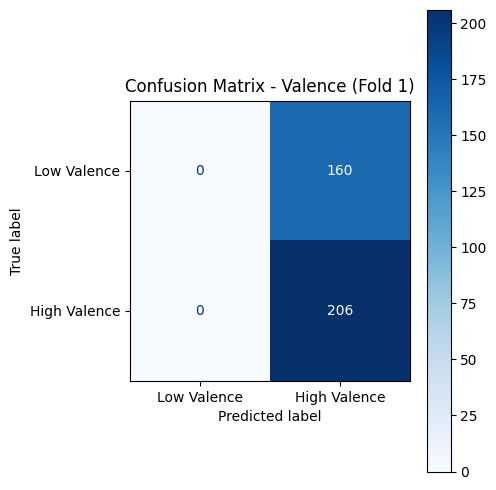


===== Fold 2 (Valensi) =====
  Jumlah sampel pelatihan: 1411, Jumlah sampel pengujian: 365
  Jumlah subjek pelatihan: 38, Jumlah subjek pengujian: 10
  Melatih Stacking Classifier untuk Valensi...
  Valence Accuracy (Fold 2): 0.7123
  Classification Report (Fold 2):
              precision    recall  f1-score   support

 Low Valence       0.00      0.00      0.00       105
High Valence       0.71      1.00      0.83       260

    accuracy                           0.71       365
   macro avg       0.36      0.50      0.42       365
weighted avg       0.51      0.71      0.59       365



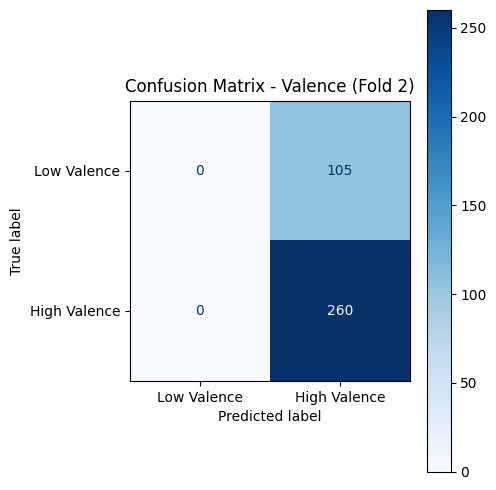


===== Fold 3 (Valensi) =====
  Jumlah sampel pelatihan: 1415, Jumlah sampel pengujian: 361
  Jumlah subjek pelatihan: 38, Jumlah subjek pengujian: 10
  Melatih Stacking Classifier untuk Valensi...
  Valence Accuracy (Fold 3): 0.5706
  Classification Report (Fold 3):
              precision    recall  f1-score   support

 Low Valence       0.00      0.00      0.00       155
High Valence       0.57      1.00      0.73       206

    accuracy                           0.57       361
   macro avg       0.29      0.50      0.36       361
weighted avg       0.33      0.57      0.41       361



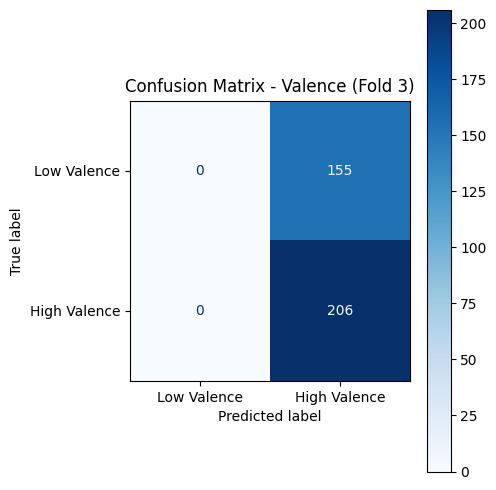


===== Fold 4 (Valensi) =====
  Jumlah sampel pelatihan: 1434, Jumlah sampel pengujian: 342
  Jumlah subjek pelatihan: 39, Jumlah subjek pengujian: 9
  Melatih Stacking Classifier untuk Valensi...
  Valence Accuracy (Fold 4): 0.6199
  Classification Report (Fold 4):
              precision    recall  f1-score   support

 Low Valence       0.00      0.00      0.00       130
High Valence       0.62      1.00      0.77       212

    accuracy                           0.62       342
   macro avg       0.31      0.50      0.38       342
weighted avg       0.38      0.62      0.47       342



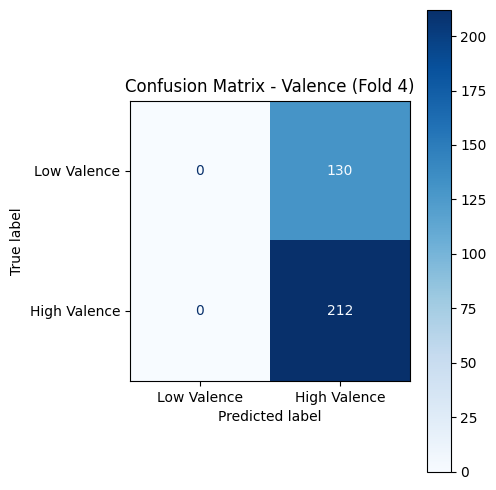


===== Fold 5 (Valensi) =====
  Jumlah sampel pelatihan: 1434, Jumlah sampel pengujian: 342
  Jumlah subjek pelatihan: 39, Jumlah subjek pengujian: 9
  Melatih Stacking Classifier untuk Valensi...
  Valence Accuracy (Fold 5): 0.6550
  Classification Report (Fold 5):
              precision    recall  f1-score   support

 Low Valence       0.00      0.00      0.00       118
High Valence       0.65      1.00      0.79       224

    accuracy                           0.65       342
   macro avg       0.33      0.50      0.40       342
weighted avg       0.43      0.65      0.52       342



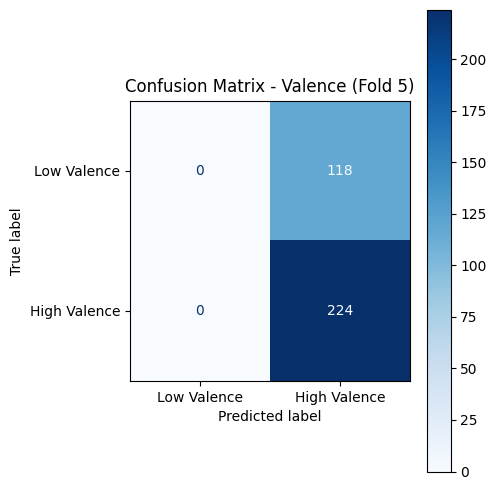


=== Ringkasan Hasil Valensi (Klasifikasi) ===
Akurasi Valensi Rata-rata: 0.6241 ± 0.0554

Rata-rata Classification Report:
              precision    recall  f1-score  support
Low Valence    0.000000  0.000000  0.000000    133.6
High Valence   0.624132  1.000000  0.767155    221.6
macro avg      0.312066  0.500000  0.383577    355.2
weighted avg   0.392614  0.624132  0.481110    355.2


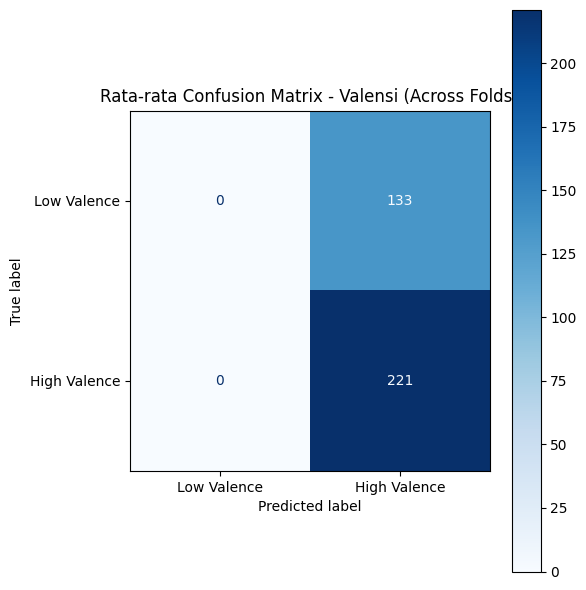

In [7]:
# --- GroupKFold Cross-Validation untuk Valensi ---
cv_valence = GroupKFold(n_splits=5)
valence_accuracies = []
valence_reports = []
confusion_matrices = [] # Untuk menyimpan confusion matrix setiap fold

print(f"\nMemulai GroupKFold Cross-Validation untuk Valensi dengan {cv_valence.n_splits} folds...")

# Pastikan X_scaled_df tidak kosong
if X_scaled_df.empty:
    print("Tidak ada data fitur yang valid untuk melatih model valensi.")
else:
    # Menggunakan indeks DataFrame untuk GroupKFold
    for fold, (train_idx, test_idx) in enumerate(cv_valence.split(X_scaled_df, y_valence, groups)):
        print(f"\n===== Fold {fold + 1} (Valensi) =====")

        # Memisahkan data berdasarkan indeks GroupKFold
        X_train_fold = X_scaled_df.iloc[train_idx].values
        X_test_fold = X_scaled_df.iloc[test_idx].values
        y_train_fold = y_valence[train_idx]
        y_test_fold = y_valence[test_idx]
        groups_train_fold = groups[train_idx] # Subjek pelatihan
        groups_test_fold = groups[test_idx]   # Subjek pengujian

        print(f"  Jumlah sampel pelatihan: {len(X_train_fold)}, Jumlah sampel pengujian: {len(X_test_fold)}")
        print(f"  Jumlah subjek pelatihan: {len(np.unique(groups_train_fold))}, Jumlah subjek pengujian: {len(np.unique(groups_test_fold))}")

        if len(X_train_fold) == 0 or len(X_test_fold) == 0:
            print(f"  Peringatan: Data pelatihan atau pengujian kosong di Fold {fold + 1}. Melewatkan fold ini.")
            continue

        # Inisialisasi dan latih Stacking Classifier
        # Base estimators
        estimators_clf = [
            ('rf', RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)),
            ('gb', GradientBoostingClassifier(n_estimators=50, random_state=42)),
            ('svc', SVC(kernel='linear', probability=True, random_state=42))
        ]
        # Final estimator
        final_estimator_clf = LogisticRegression(random_state=42)

        clf_stack = StackingClassifier(
            estimators=estimators_clf,
            final_estimator=final_estimator_clf,
            cv=3, # Internal CV for stacking, can be different from outer CV
            n_jobs=-1
        )

        print("  Melatih Stacking Classifier untuk Valensi...")
        clf_stack.fit(X_train_fold, y_train_fold)

        # Prediksi dan Evaluasi
        y_pred_fold = clf_stack.predict(X_test_fold)
        acc_fold = accuracy_score(y_test_fold, y_pred_fold)
        report_fold = classification_report(y_test_fold, y_pred_fold, target_names=["Low Valence", "High Valence"], output_dict=True, zero_division=0)
        cm_fold = confusion_matrix(y_test_fold, y_pred_fold, labels=[0, 1])

        valence_accuracies.append(acc_fold)
        valence_reports.append(report_fold)
        confusion_matrices.append(cm_fold)

        print(f"  Valence Accuracy (Fold {fold + 1}): {acc_fold:.4f}")
        print(f"  Classification Report (Fold {fold + 1}):\n{classification_report(y_test_fold, y_pred_fold, target_names=['Low Valence', 'High Valence'], zero_division=0)}")

        # Visualisasi Confusion Matrix untuk setiap fold
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_fold, display_labels=["Low Valence", "High Valence"])
        fig, ax = plt.subplots(figsize=(5, 5))
        disp.plot(cmap=plt.cm.Blues, ax=ax)
        ax.set_title(f"Confusion Matrix - Valence (Fold {fold + 1})")
        plt.tight_layout()
        plt.show() # Tampilkan plot untuk setiap fold
        # plt.savefig(f"confusion_matrix_valence_fold_{fold+1}.png") # Atau simpan ke file
        # plt.close()

# --- Ringkasan Hasil Valensi ---
print("\n=== Ringkasan Hasil Valensi (Klasifikasi) ===")
if valence_accuracies:
    print(f"Akurasi Valensi Rata-rata: {np.mean(valence_accuracies):.4f} ± {np.std(valence_accuracies):.4f}")

    # Hitung rata-rata metrik dari classification_report
    # Perbaikan: Mengambil rata-rata dari dict report dengan hati-hati
    avg_report = {}
    if valence_reports:
        # Kumpulkan semua metrik untuk setiap label
        metrics_per_label = {label: {metric: [] for metric in ["precision", "recall", "f1-score", "support"]}
                             for label in ["Low Valence", "High Valence", "macro avg", "weighted avg"]}

        for r_dict in valence_reports:
            for label, metrics in r_dict.items():
                if label in metrics_per_label: # Hanya proses label yang kita inginkan
                    for metric, value in metrics.items():
                        if metric in metrics_per_label[label]:
                            metrics_per_label[label][metric].append(value)
        
        # Hitung rata-rata untuk setiap metrik
        for label, metrics in metrics_per_label.items():
            avg_report[label] = {metric: np.mean(values) if values else 0
                                 for metric, values in metrics.items()}
    
    # Cetak rata-rata classification report
    print("\nRata-rata Classification Report:")
    if avg_report:
        print(pd.DataFrame(avg_report).transpose().to_string())
    else:
        print("Tidak dapat membuat rata-rata classification report.")

    # Visualisasi rata-rata Confusion Matrix (jika ada)
    if confusion_matrices:
        avg_cm = np.mean(confusion_matrices, axis=0).astype(int)
        disp_avg = ConfusionMatrixDisplay(confusion_matrix=avg_cm, display_labels=["Low Valence", "High Valence"])
        fig_avg, ax_avg = plt.subplots(figsize=(6, 6))
        disp_avg.plot(cmap=plt.cm.Blues, ax=ax_avg)
        ax_avg.set_title("Rata-rata Confusion Matrix - Valensi (Across Folds)")
        plt.tight_layout()
        plt.show()
        # plt.savefig("avg_confusion_matrix_valence.png")
        # plt.close()

else:
    print("Tidak ada skor akurasi valensi yang terekam.")



Memulai GroupKFold Cross-Validation untuk Gairah dengan 5 folds...

===== Fold 1 (Gairah) =====
  Jumlah sampel pelatihan: 1410, Jumlah sampel pengujian: 366
  Jumlah subjek pelatihan: 38, Jumlah subjek pengujian: 10
  Melatih Stacking Regressor untuk Gairah...
  Arousal MAE (Fold 1): 1.7160, RMSE: 1.9500, R2: 0.0072


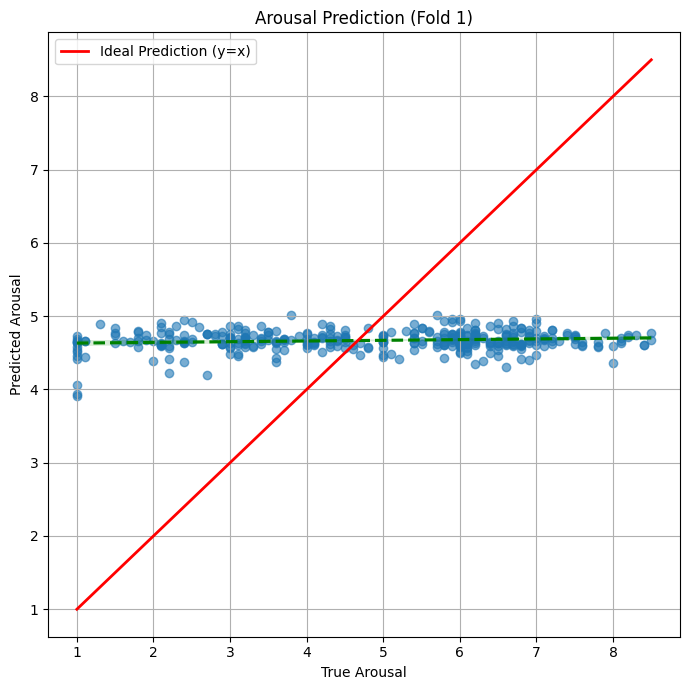


===== Fold 2 (Gairah) =====
  Jumlah sampel pelatihan: 1411, Jumlah sampel pengujian: 365
  Jumlah subjek pelatihan: 38, Jumlah subjek pengujian: 10
  Melatih Stacking Regressor untuk Gairah...
  Arousal MAE (Fold 2): 1.5025, RMSE: 1.7206, R2: -0.0037


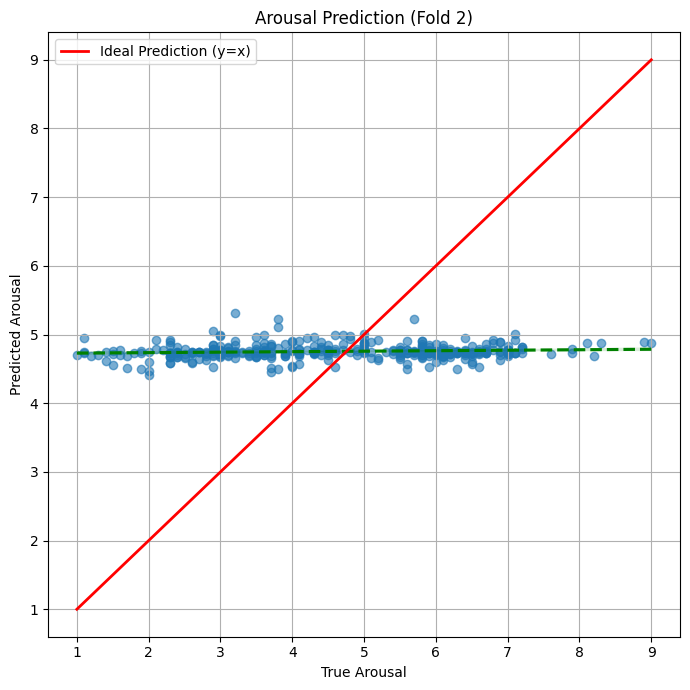


===== Fold 3 (Gairah) =====
  Jumlah sampel pelatihan: 1415, Jumlah sampel pengujian: 361
  Jumlah subjek pelatihan: 38, Jumlah subjek pengujian: 10
  Melatih Stacking Regressor untuk Gairah...
  Arousal MAE (Fold 3): 1.6954, RMSE: 1.9858, R2: -0.0079


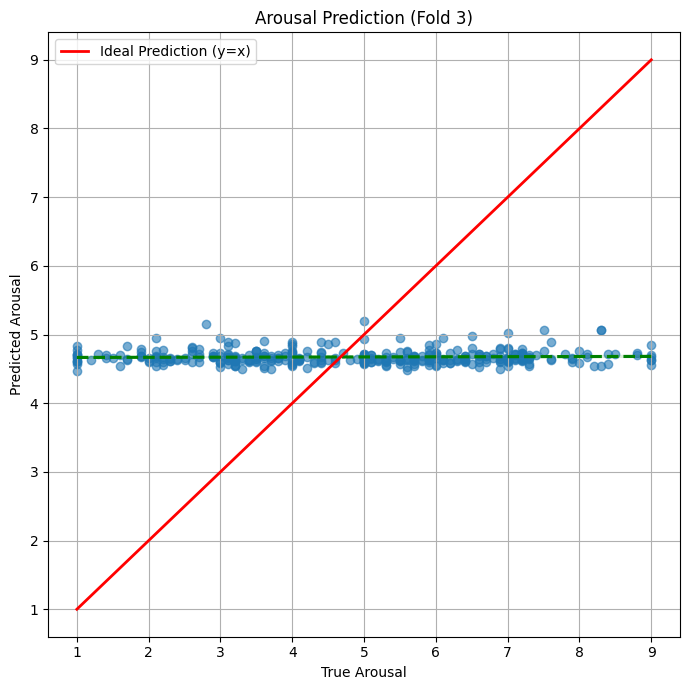


===== Fold 4 (Gairah) =====
  Jumlah sampel pelatihan: 1434, Jumlah sampel pengujian: 342
  Jumlah subjek pelatihan: 39, Jumlah subjek pengujian: 9
  Melatih Stacking Regressor untuk Gairah...
  Arousal MAE (Fold 4): 1.6824, RMSE: 1.9950, R2: -0.0104


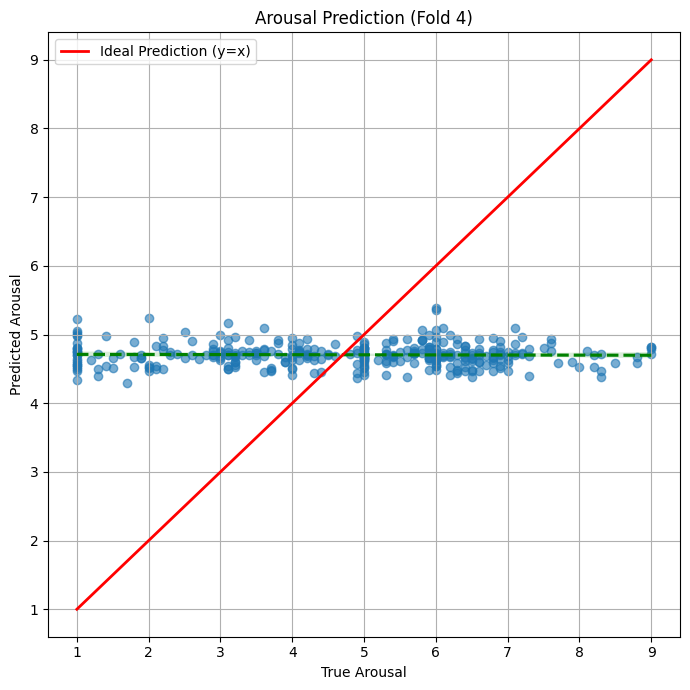


===== Fold 5 (Gairah) =====
  Jumlah sampel pelatihan: 1434, Jumlah sampel pengujian: 342
  Jumlah subjek pelatihan: 39, Jumlah subjek pengujian: 9
  Melatih Stacking Regressor untuk Gairah...
  Arousal MAE (Fold 5): 1.7301, RMSE: 2.0858, R2: -0.0236


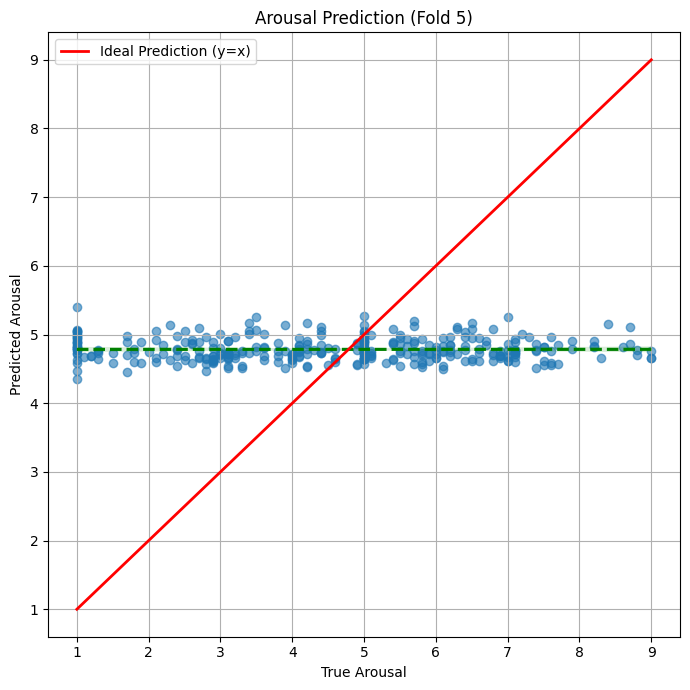


=== Ringkasan Hasil Gairah (Regresi) ===
Arousal MAE Rata-rata: 1.6653 ± 0.0830
Arousal RMSE Rata-rata: 1.9475 ± 0.1219
Arousal R2 Rata-rata: -0.0077 ± 0.0100


In [9]:
# --- GroupKFold Cross-Validation untuk Gairah ---
cv_arousal = GroupKFold(n_splits=5)
arousal_maes = []
arousal_rmses = []
arousal_r2s = []

print(f"\nMemulai GroupKFold Cross-Validation untuk Gairah dengan {cv_arousal.n_splits} folds...")

if X_scaled_df.empty:
    print("Tidak ada data fitur yang valid untuk melatih model gairah.")
else:
    for fold, (train_idx, test_idx) in enumerate(cv_arousal.split(X_scaled_df, y_arousal, groups)):
        print(f"\n===== Fold {fold + 1} (Gairah) =====")

        X_train_fold = X_scaled_df.iloc[train_idx].values
        X_test_fold = X_scaled_df.iloc[test_idx].values
        y_train_fold = y_arousal[train_idx]
        y_test_fold = y_arousal[test_idx]
        groups_train_fold = groups[train_idx]
        groups_test_fold = groups[test_idx]

        print(f"  Jumlah sampel pelatihan: {len(X_train_fold)}, Jumlah sampel pengujian: {len(X_test_fold)}")
        print(f"  Jumlah subjek pelatihan: {len(np.unique(groups_train_fold))}, Jumlah subjek pengujian: {len(np.unique(groups_test_fold))}")

        if len(X_train_fold) == 0 or len(X_test_fold) == 0:
            print(f"  Peringatan: Data pelatihan atau pengujian kosong di Fold {fold + 1}. Melewatkan fold ini.")
            continue

        # Inisialisasi dan latih Stacking Regressor
        # Base estimators
        estimators_reg = [
            ('rf', RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)),
            ('gb', GradientBoostingRegressor(n_estimators=50, random_state=42)),
            ('svr', SVR(kernel='linear'))
        ]
        # Final estimator
        final_estimator_reg = Ridge(random_state=42)

        reg_stack = StackingRegressor(
            estimators=estimators_reg,
            final_estimator=final_estimator_reg,
            cv=3, # Internal CV for stacking
            n_jobs=-1
        )

        print("  Melatih Stacking Regressor untuk Gairah...")
        reg_stack.fit(X_train_fold, y_train_fold)

        # Prediksi dan Evaluasi
        y_pred_ar_fold = reg_stack.predict(X_test_fold)
        mae_fold = mean_absolute_error(y_test_fold, y_pred_ar_fold)
        rmse_fold = np.sqrt(mean_squared_error(y_test_fold, y_pred_ar_fold))
        r2_fold = r2_score(y_test_fold, y_pred_ar_fold)

        arousal_maes.append(mae_fold)
        arousal_rmses.append(rmse_fold)
        arousal_r2s.append(r2_fold)

        print(f"  Arousal MAE (Fold {fold + 1}): {mae_fold:.4f}, RMSE: {rmse_fold:.4f}, R2: {r2_fold:.4f}")

        # --- PERUBAHAN VISUALISASI DI SINI ---
        plt.figure(figsize=(7, 7))
        # Gunakan seaborn.regplot untuk plot scatter dan garis regresi yang di-fit
        sns.regplot(x=y_test_fold, y=y_pred_ar_fold, scatter_kws={'alpha':0.6}, line_kws={'color':'green', 'linestyle':'--'}, ci=95)
        # Tambahkan garis ideal y=x
        plt.plot([min(y_test_fold), max(y_test_fold)], [min(y_test_fold), max(y_test_fold)], 'r-', lw=2, label='Ideal Prediction (y=x)') # Garis ideal
        plt.xlabel("True Arousal")
        plt.ylabel("Predicted Arousal")
        plt.title(f"Arousal Prediction (Fold {fold + 1})")
        plt.grid(True)
        plt.legend() # Tambahkan legenda untuk membedakan garis
        plt.tight_layout()
        plt.show()
        # --- AKHIR PERUBAHAN ---

# --- Ringkasan Hasil Gairah ---
print("\n=== Ringkasan Hasil Gairah (Regresi) ===")
if arousal_maes:
    print(f"Arousal MAE Rata-rata: {np.mean(arousal_maes):.4f} ± {np.std(arousal_maes):.4f}")
    print(f"Arousal RMSE Rata-rata: {np.mean(arousal_rmses):.4f} ± {np.std(arousal_rmses):.4f}")
    print(f"Arousal R2 Rata-rata: {np.mean(arousal_r2s):.4f} ± {np.std(arousal_r2s):.4f}")
else:
    print("Tidak ada skor gairah yang terekam.")
